First 5 rows of dataset:
  Order_ID       Customer_Location     Restaurant_Location  Distance  \
0  ORD0001  (17.030479, 79.743077)  (12.358515, 85.100083)      1.57   
1  ORD0002  (15.398319, 86.639122)  (14.174874, 77.025606)     21.32   
2  ORD0003  (15.687342, 83.888808)  (19.594748, 82.048482)      6.95   
3  ORD0004  (20.415599, 78.046984)  (16.915906, 78.278698)     13.79   
4  ORD0005  (14.786904, 78.706532)  (15.206038, 86.203182)      6.72   

  Weather_Conditions Traffic_Conditions  Delivery_Person_Experience  \
0              Rainy             Medium                           4   
1             Cloudy             Medium                           8   
2              Snowy             Medium                           9   
3             Cloudy                Low                           2   
4              Rainy               High                           6   

  Order_Priority Order_Time Vehicle_Type  Restaurant_Rating  Customer_Rating  \
0         Medium  Afternoon        

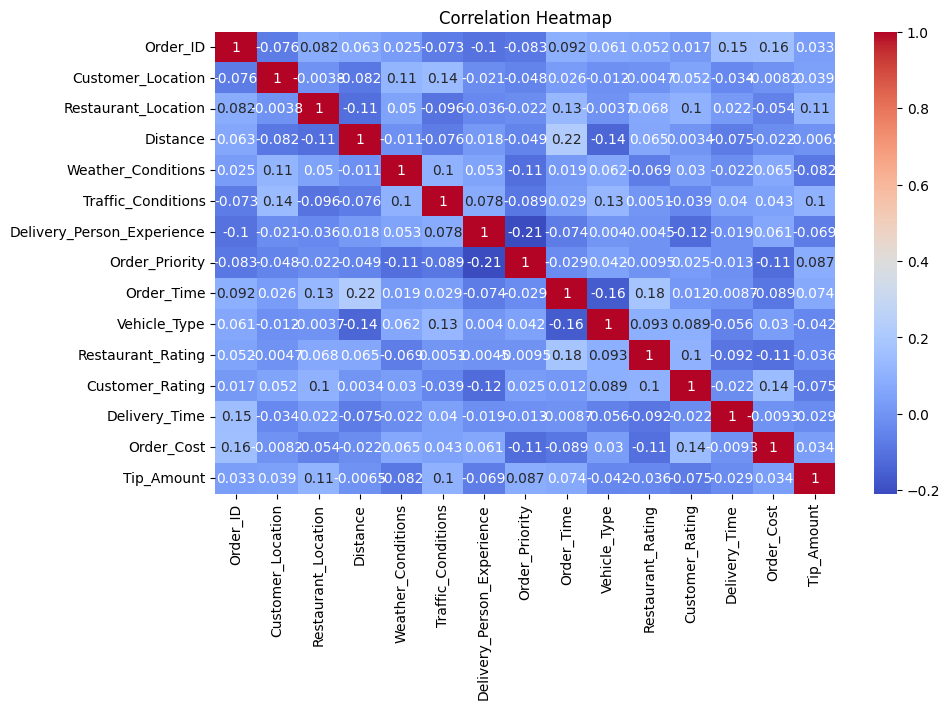

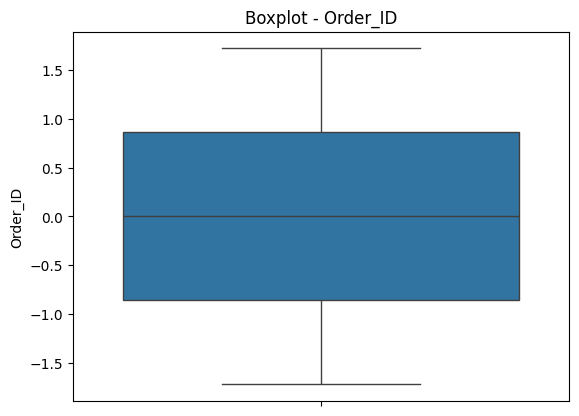

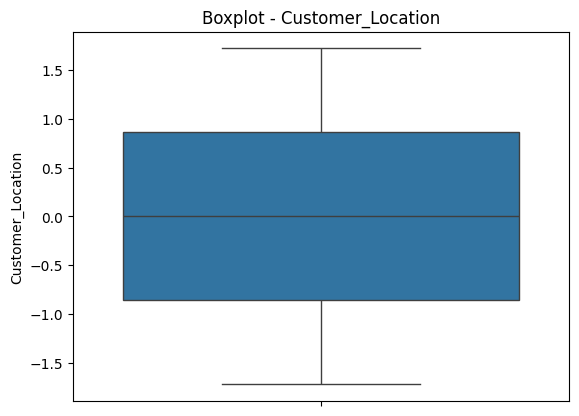

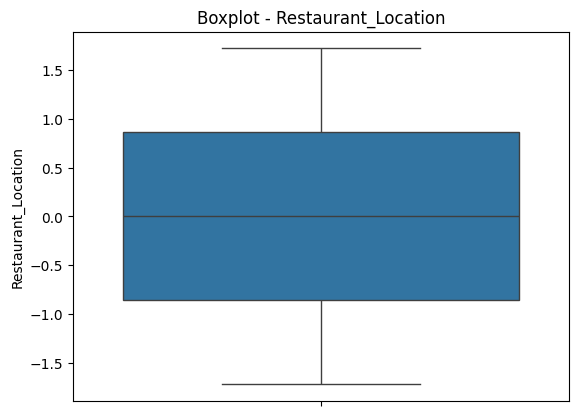

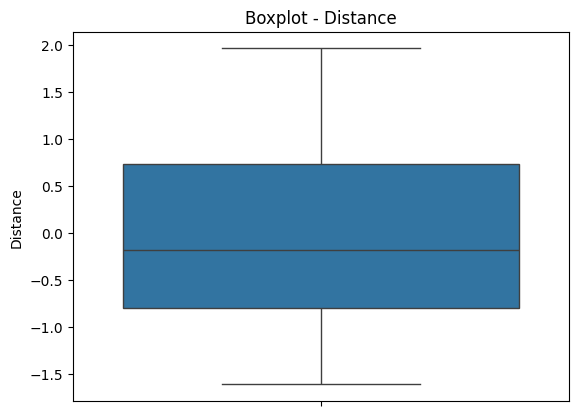

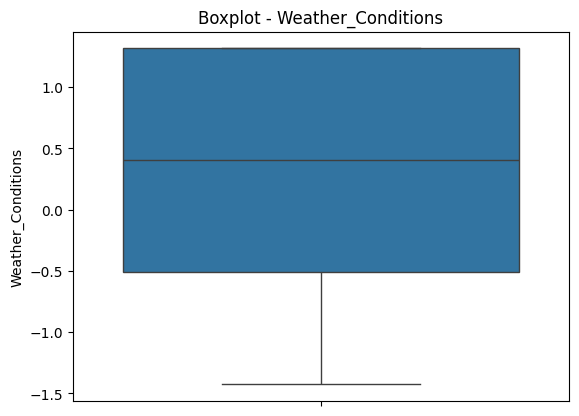

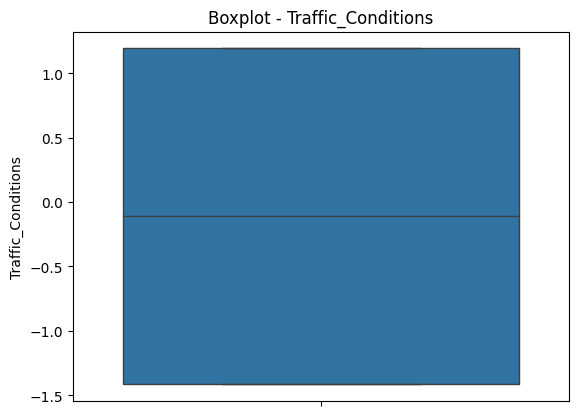

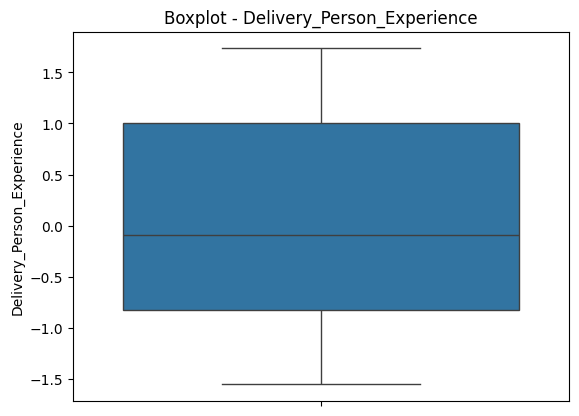

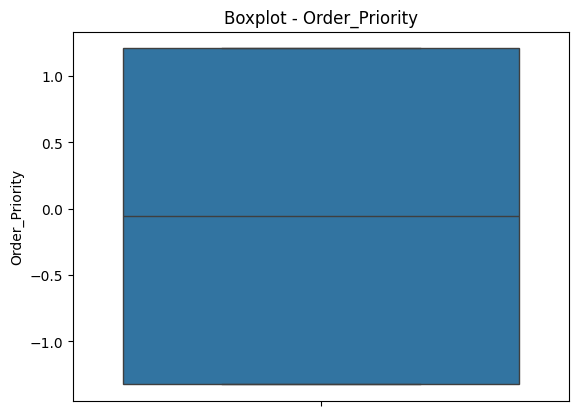

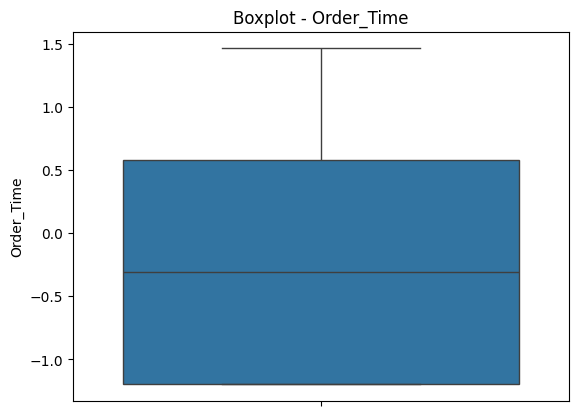

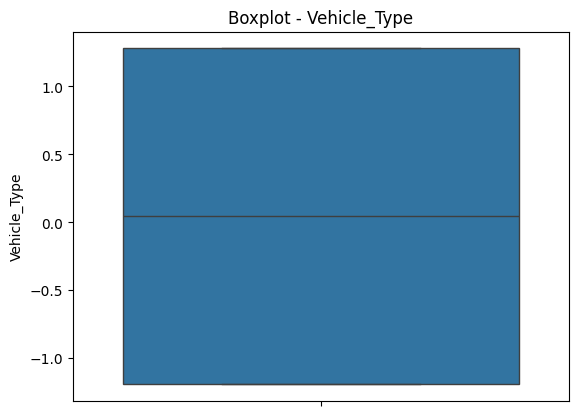

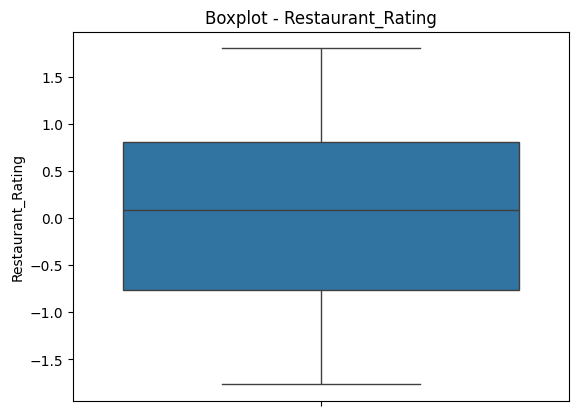

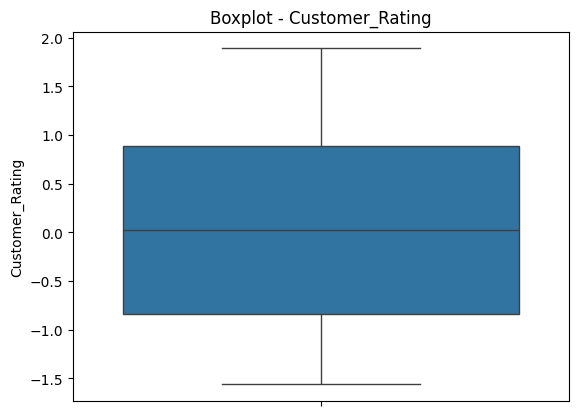

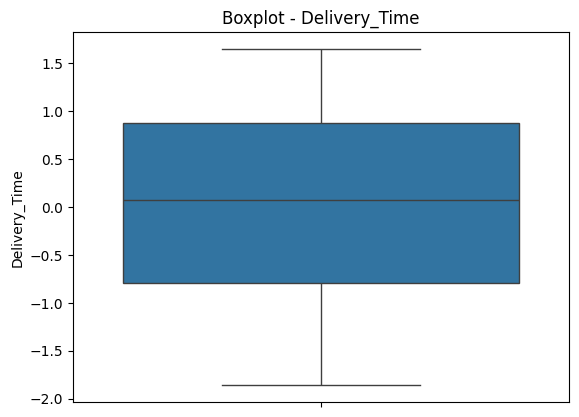

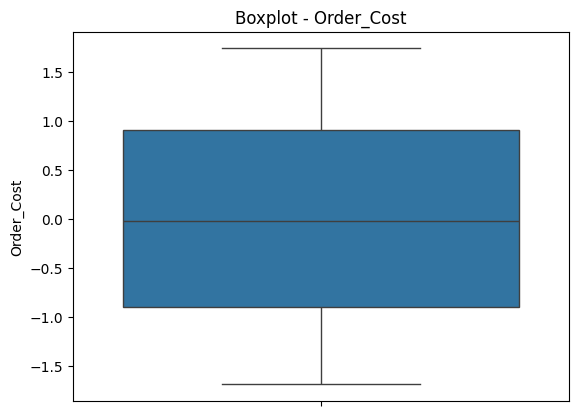

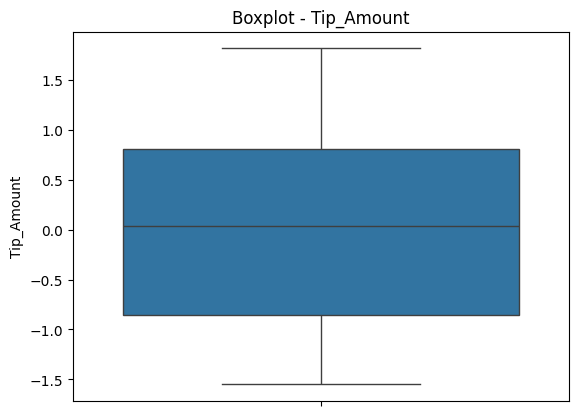


--- Linear Regression Evaluation ---
MSE: 1.0050655621571303
MAE: 0.8560688013227991
R2 Score: 0.03782616065457334

--- Logistic Regression Evaluation ---
Accuracy: 0.525
Precision: 0.5
Recall: 0.5263157894736842
F1 Score: 0.5128205128205128
Confusion Matrix:
 [[11 10]
 [ 9 10]]


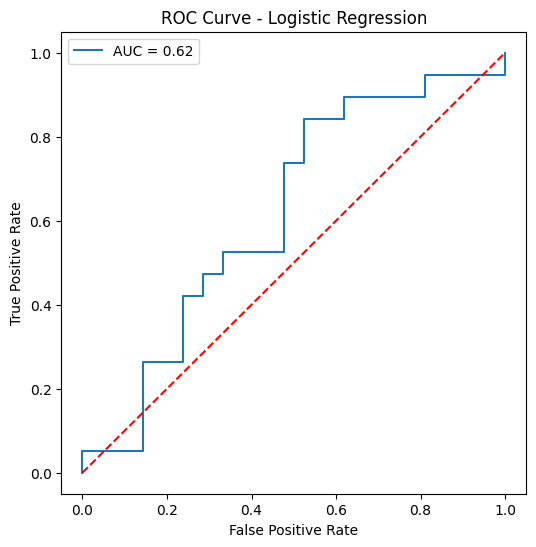

In [1]:
# Food Delivery Time Prediction Project
# ================================
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# ================================
# Step 1: Load Data
df = pd.read_csv("Food_Delivery_Time_Prediction (1).csv")

print("First 5 rows of dataset:")
print(df.head())
print("\nInfo:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# ================================
# Step 2: Handle Missing Values
df.fillna(df.mean(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

# ================================
# Step 3: Encode Categorical Variables
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# ================================
# Step 4: Normalize Numerical Features
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['int64','float64']).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# ================================
# Step 5: EDA
print("\nDescriptive Statistics:")
print(df.describe())

# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Boxplots for Outliers
for col in numeric_cols:
    plt.figure()
    sns.boxplot(df[col])
    plt.title(f"Boxplot - {col}")
    plt.show()

# ================================
# Step 6: Feature Engineering (example distance + rush hour)
if "Restaurant_lat" in df.columns and "Restaurant_long" in df.columns and "Customer_lat" in df.columns and "Customer_long" in df.columns:
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371
        dlat = np.radians(lat2-lat1)
        dlon = np.radians(lon2-lon1)
        a = np.sin(dlat/2)*2 + np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*np.sin(dlon/2)*2
        return 2*R*np.arcsin(np.sqrt(a))
    df["Distance"] = df.apply(lambda row: haversine(row["Restaurant_lat"], row["Restaurant_long"],
                                                    row["Customer_lat"], row["Customer_long"]), axis=1)

if "Order_Time" in df.columns:
 def is_rush_hour(x):
    try:
        hour = int(x)  # take the integer part as the hour
        if 11 <= hour <= 14 or 18 <= hour <= 21:
            return 1
        else:
            return 0
    except:
        return 0

df["Rush_Hour"] = df["Order_Time"].apply(is_rush_hour)


# ================================
# Step 7: Linear Regression (Predict Delivery Time)
X = df.drop(columns=["Delivery_Time"])
y = df["Delivery_Time"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

print("\n--- Linear Regression Evaluation ---")
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

# ================================
# Step 8: Logistic Regression (Classify Fast/Delayed)
# Create Binary Target: Fast (<= median) vs Delayed (> median)
median_time = y.median()
df["Status"] = df["Delivery_Time"].apply(lambda x: 1 if x <= median_time else 0)

X = df.drop(columns=["Delivery_Time","Status"])
y = df["Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("\n--- Logistic Regression Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC Curve
y_prob = log_reg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label="AUC = {:.2f}".format(roc_auc))
plt.plot([0,1],[0,1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()